Due to challenges faced trying to access the blockchain data en masse, i created a local instance of the lbry-explorer and this notebook leverages the mongoDB data source that exists as part of the lbry-explorer.

In [51]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
import getpass
password = getpass.getpass()

········


In [20]:
def connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]


def read_mongo(db, collection, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """

    # Connect to MongoDB
    db = connect_mongo(host=host, port=port, username=username, password=password, db=db)
    
    # Make a query to the specific DB and Collection
    cursor = db[collection].find()
    #print list(cursor)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df.drop("__v", axis=1)

Collections:
    addresses,
    markets,
    richlists,
    stats,
    txes

In [39]:
db = "explorerdb"

In [40]:
address_df = read_mongo(db, "addresses", host='localhost', port=27017, username="zargham", password=password)

In [41]:
address_df[address_df.a_id.map(lambda s: bool((s[0] != "b") & (s[0] !="r")))].head()

,a_id,balance,received,sent,txs
0,coinbase,0,0,6.310887e+14,"[{u'type': u'vin', u'addresses': u'5dda81f4219..."


In [42]:
labels = {"rEQKyb7nd7UUGyEEn5xRkk1fgXdTCf2ZCg": {"label":"LBRY Team", "type":"info", "url":"https://lbry.io/what#credits"},
      "bWbFyN8CJAghwavfRDuEfmv71swkapBcuy": {"label":"LBRY Hot Wallet", "type":"info", "url":""},
      "rVRMmGLZenVXpT1NwYMGcnwFc642kEgWTV": {"label":"Strategic Partners", "type":"info", "url":"https://lbry.io/what#credits"},
      "bLPbiXBp6Vr3NSnsHzDsLNzoy5o36re9Cz": {"label":"Investor", "type":"info", "url":"https://lbry.io/news/mysterious-100k-lbc-revealed"},
      "rTZF9RvfkLJ6hwCwERwFd7dppRMeddKjpe": {"label":"LBRY Team", "type":"info", "url":"https://lbry.io/what#credits"},
      "bVUrbCK8hcZ5XWti7b9eNxKEBxzc1rr393": {"label":"LBRY Hot Wallet", "type":"info", "url":""},
      "bHW58d37s1hBjj3wPBkn5zpCX3F8ZW3uWf": {"label":"LBRY Team Escrow (premine)", "type":"info", "url":"https://lbry.io/what#credits"},
      "r9DarmxyPjWkF7ocyxMzaNZN3a9gJvNTZJ": {"label":"Strategic Partners", "type":"info", "url":"https://lbry.io/what#credits"},
      "rMT5Sg8SyFP3ax2PRaweRCRZoMeYw4znEi": {"label":"Adoption Programs", "type":"info", "url":"https://lbry.io/what#credits"},
      "bDzuP6Sawe7tadVKR7dmPW1JFYK9ELnjra": {"label":"LBRY Hot Wallet", "type":"info", "url":""},
      "bFgohv4wprdCEtW2m5EVQyVNtxp4NxQMXi": {"label":"LBRY Hot Wallet", "type":"info", "url":""},
      "rRmURzvpHTysU4xUSp9CXeosBTbYfKs7n5": {"label":"Adoption Programs", "type":"info", "url":"https://lbry.io/what#credits"}
    }

In [46]:
def get_label(address):
    if address in labels.keys():
        return labels[address]["label"]
    else:
        return "unknown"

In [47]:
address_df["label"] = address_df.a_id.map(get_label)

In [48]:
address_df[address_df.label != "unknown"]

,a_id,balance,received,sent,txs,label
404,rEQKyb7nd7UUGyEEn5xRkk1fgXdTCf2ZCg,0.000000e+00,1.999000e+16,1.999000e+16,"[{u'type': u'vout', u'addresses': u'32f0ab6b2a...",LBRY Team
406,rMT5Sg8SyFP3ax2PRaweRCRZoMeYw4znEi,0.000000e+00,3.980000e+16,3.980000e+16,"[{u'type': u'vout', u'addresses': u'781c100a80...",Adoption Programs
410,r9DarmxyPjWkF7ocyxMzaNZN3a9gJvNTZJ,0.000000e+00,1.000000e+16,1.000000e+16,"[{u'type': u'vout', u'addresses': u'9600945091...",Strategic Partners
424,bHW58d37s1hBjj3wPBkn5zpCX3F8ZW3uWf,4.000000e+16,0.000000e+00,4.000000e+16,"[{u'type': u'vin', u'addresses': u'9a72043e11b...",LBRY Team Escrow (premine)
4057,bLPbiXBp6Vr3NSnsHzDsLNzoy5o36re9Cz,1.000090e+13,1.000090e+13,0.000000e+00,"[{u'type': u'vout', u'addresses': u'e2f9cb21d4...",Investor
4163,bFgohv4wprdCEtW2m5EVQyVNtxp4NxQMXi,0.000000e+00,7.352650e+13,7.352650e+13,"[{u'type': u'vout', u'addresses': u'7c77646740...",LBRY Hot Wallet
4833,bVUrbCK8hcZ5XWti7b9eNxKEBxzc1rr393,2.403880e+13,4.897770e+13,2.493890e+13,"[{u'type': u'vout', u'addresses': u'ed8fc03abd...",LBRY Hot Wallet
128905,bDzuP6Sawe7tadVKR7dmPW1JFYK9ELnjra,1.450000e+14,2.984199e+14,1.534199e+14,"[{u'type': u'vout', u'addresses': u'554d8fed52...",LBRY Hot Wallet
129116,bWbFyN8CJAghwavfRDuEfmv71swkapBcuy,0.000000e+00,8.419899e+12,8.419899e+12,"[{u'type': u'vout', u'addresses': u'b72ffc5bb9...",LBRY Hot Wallet
236796,rVRMmGLZenVXpT1NwYMGcnwFc642kEgWTV,1.000000e+16,1.000000e+16,1.000000e+06,"[{u'type': u'vout', u'addresses': u'73df395c9f...",Strategic Partners


In [49]:
tx_df = read_mongo(db, "txes", host='localhost', port=27017, username="zargham", password=password)

In [54]:
import pytz
tz = pytz.timezone('America/Montreal')
tx_df["datetime"] = tx_df.timestamp.map(lambda t: datetime.datetime.fromtimestamp(int(t), tz))

In [56]:
#jacks reward function
COIN = 10**8
block_time = 150
blocks_per_ramp = 100
start_ramp_height = 5001
limit = 1083221000 * COIN
subsidy_interval = 1 << 5
max_reductions = 500
peak_reward = 500 * COIN
premine = 400000000 * COIN


def reward(n):
    assert n >= 0
    if n < 5001:
        return COIN
    elif n < 55001:
        r = 1 + ((n - ((n - start_ramp_height) % blocks_per_ramp) - start_ramp_height) / blocks_per_ramp)
        return r * COIN
    else:
        level = int((n - 55001) / subsidy_interval)
        reduction = int((-1 + int((8 * level) + 1) ** 0.5) / 2)
        while level >= ((reduction * reduction + reduction) >> 1):
            if ((reduction * reduction + reduction) >> 1) > level:
                reduction -= 1
            else:
                reduction += 1
        if reduction * COIN >= peak_reward:
            return 0
        return peak_reward - (reduction * COIN)

In [57]:
tx_df["reward"] = tx_df.blockindex.map(reward)

In [59]:
tx_df.tail()

,blockhash,blockindex,timestamp,total,txid,vin,vout,datetime,reward
387843,1860ca61ee065062df0a4c2d0775b45a5a435491dcb0ac...,40463,1473119388,33602537760,f9dd563281435859bf28f42dd15d777cdf24215e6b16a9...,"[{u'amount': 33602549106.0, u'addresses': u'bJ...","[{u'amount': 33486072917.0, u'addresses': u'bH...",2016-09-05 19:49:48-04:00,35500000000
387844,1860ca61ee065062df0a4c2d0775b45a5a435491dcb0ac...,40463,1473119388,3810676987,14745eaadf4e3d345367408ea56849e348691679e9e666...,"[{u'amount': 3810688333.0, u'addresses': u'bPJ...","[{u'amount': 1223536962, u'addresses': u'bZ3Qx...",2016-09-05 19:49:48-04:00,35500000000
387845,1860ca61ee065062df0a4c2d0775b45a5a435491dcb0ac...,40463,1473119388,11228406126,e448f6c6de7ae529d9cd86ff2d6148ff377461f9ef73ca...,"[{u'amount': 11228417472.0, u'addresses': u'bF...","[{u'amount': 119786283, u'addresses': u'bVgiHH...",2016-09-05 19:49:48-04:00,35500000000
387846,1860ca61ee065062df0a4c2d0775b45a5a435491dcb0ac...,40463,1473119388,9043744690,28ef72ec06b2bc14b7ae0e3ee3035cbbbadf36217e84e7...,"[{u'amount': 9043756036.0, u'addresses': u'bRu...","[{u'amount': 169500795, u'addresses': u'bGFtt2...",2016-09-05 19:49:48-04:00,35500000000
387847,1860ca61ee065062df0a4c2d0775b45a5a435491dcb0ac...,40463,1473119388,15281455904,0af9162cffe1ec8bfad1b9984bd3582959b1ea0f1d7774...,"[{u'amount': 15281467250.0, u'addresses': u'bR...","[{u'amount': 14781077106.0, u'addresses': u'bY...",2016-09-05 19:49:48-04:00,35500000000


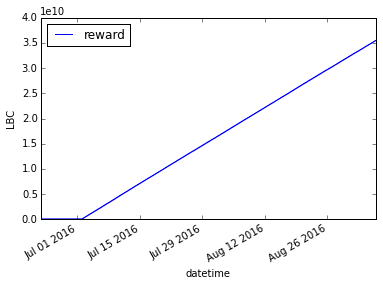

In [63]:
tx_df.plot(x="datetime", y= "reward")
plt.ylabel("LBC")